# Cross-Domain Neural Networks for JPEG Decompression

This Jupyter Notebook trains cross-domain neural network models for JPEG decompression.

<a href=#data>Load Data</a>

<a href=#networka>Network A</a>: DCT-Image Domain W-net

<a href=#networkb>Network B</a>: DFT-Image Domain W-net

<a href=#networkc>Network C</a>: DCT-Image Domain Fully-Connected U-net

<a href=#networkd>Network D</a>: DFT-Image Domain Fully-Connected CNN

<a href=#scratchpad>Scratchpad</a>: Testing things

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.backend import eval as tf_eval

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
#from cs_models import deep_cascade_unet_no_dc, deep_cascade_unet, deep_cascade_unet_ksp_no_dc, \
#dequantization_network, deep_cascade_fc_unet
from dctools import py_dct2d, py_idct2d, dct_in_blocks, idct_in_blocks, get_quantization_matrix, \
extract_image_patches, compile_image_patches

Using TensorFlow backend.


# =============================================================
<a name='data'/>

In [3]:
# Some network parameters

H,W = 256, 256
norm = 128.0
compr_range = (10,20)

epochs = 100
batch_size= 8
lr = 0.001
patience = 10 # early stopping

useDC = True

useImageNet = True

# Load Data

In [4]:
# Train and validation data paths

if useImageNet:
    images_path = "../../ImageNet/*.tif"
    images = glob.glob(images_path)
    print(len(images))
    # Listing train and validation images
    train_images = images[0:30000]
    val_images = images[30000:45000]
    test_images = images[45000:]
#     train_images = images[0:100]
#     val_images = images[30000:30050]
#     test_images = images[45000:]

    # Summary of images
    print("Train set size:", len(train_images))
    print("Validation set size:",len(val_images))
    print("Test set size:",len(test_images))
    
else:
    # Train and validation data paths
    train_path = "../../MRDataset/Development/Training/*.tif"
    val_path = "../../MRDataset/Development/Validation/*.tif"
    test_path = "../../MRDataset/Testing/*.tif"

    # Listing train and validation images
    train_images = glob.glob(train_path)
    val_images = glob.glob(val_path)
    test_images = glob.glob(test_path)

    # Summary of images
    print("Train set size:", len(train_images))
    print("Validation set size:",len(val_images))
    print("Testing set size:",len(test_images))

48627
Train set size: 30000
Validation set size: 15000
Test set size: 3627


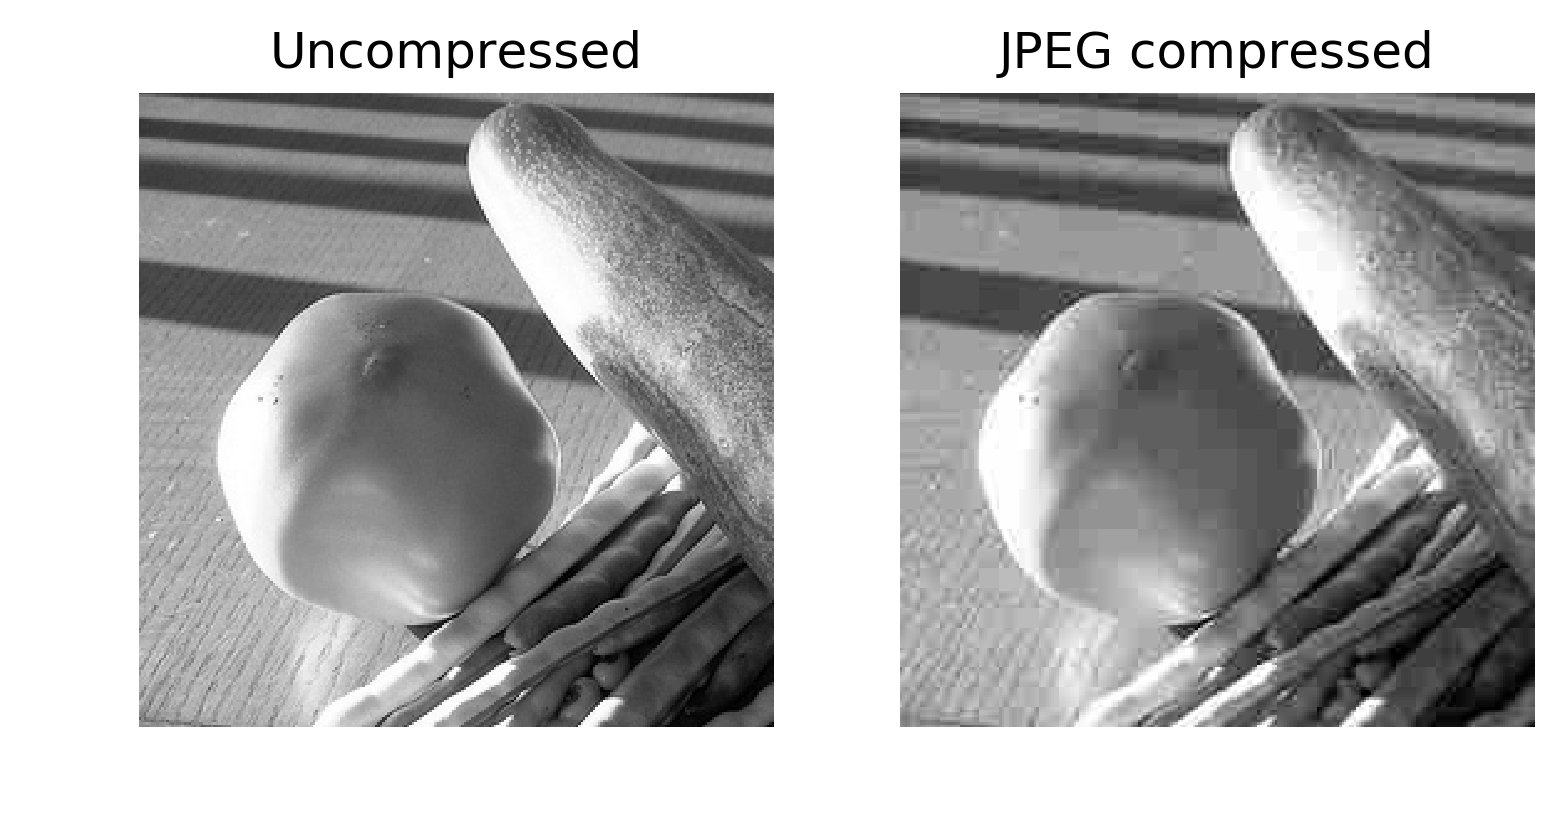

In [5]:
# Load uncompressed image
im1 = Image.open(train_images[50])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure(dpi=300)
plt.subplot(1,2,1)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [6]:
train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_qmat = np.zeros((len(val_images),H,W,1),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = np.zeros_like(train_unc)
val_compr = np.zeros_like(val_unc)

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
    
    # Get the quantization matrix and arrange the matrix into 8x8 patches (JPEG standard)
    val_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))

# Normalize all images by centering image values around 0 (subtract by 128.0) and dividing by 128.0
# Centering the image values around 0 is the JPEG compression standard
val_unc -= norm
val_unc /= norm

val_compr -= norm
val_compr /= norm

val_qmat /= norm

(15000, 256, 256, 1)
-1.0 0.703125 -0.4257791
-1.0 0.6796875 -0.42469525


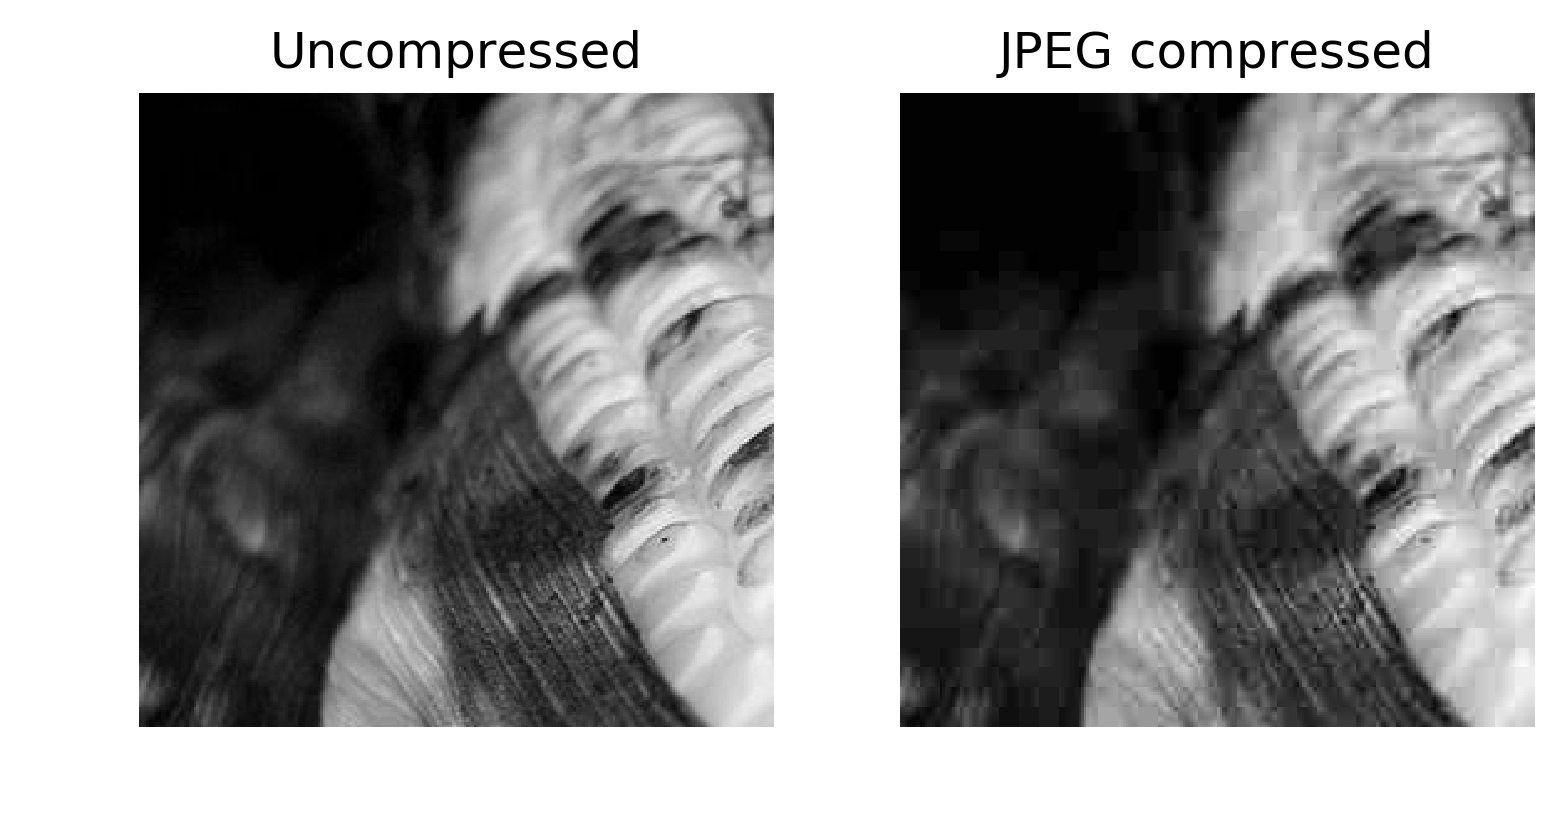

In [7]:
nn = 50

print(val_unc.shape)
print(val_unc[nn,:,:,0].min(),val_unc[nn,:,:,0].max(), val_unc[nn,:,:,0].mean())
print(val_compr[nn,:,:,0].min(),val_compr[nn,:,:,0].max(), val_compr[nn,:,:,0].mean())

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure(dpi=300)
plt.subplot(1,2,1)
plt.imshow(val_unc[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(val_compr[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [8]:
# Data augmentation of training data

def combine_generator_no_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
        yield((batch_comp-norm)/norm, (batch_unc-norm)/ norm)
        
        
def combine_generator_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        train_qmat = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            train_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))
            
        yield([(batch_comp-norm)/norm, train_qmat/norm], [(batch_unc-norm)/norm,(batch_unc-norm)/norm])

        
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

# combine generators into one which yields image and masks
if useDC:
    combined = combine_generator_dc(image_generator1,compr_range)
else:
    combined = combine_generator_no_dc(image_generator1,compr_range)

In [10]:
# # sample data augmentation
# if useDC:
#     for ii in combined:
#         print(ii[0][0].shape)
#         print(ii[0][0].min(),ii[0][0].max(), ii[0][0].mean())
#         print(ii[1].min(),ii[1].max(), ii[1].mean())
#         plt.figure()
#         plt.subplot(121)
#         plt.imshow(ii[0][0][2,:,:,0],cmap = 'gray')
#         plt.axis("off")
#         plt.subplot(122)
#         plt.imshow(ii[1][2,:,:,0],cmap = 'gray')
#         plt.axis("off")
#         plt.show()
#         break
# else:
#     for ii in combined:
#         print(ii[0][0].shape, ii[1][0].shape)
#         print(ii[0][0].min(),ii[0][0].max())
#         print(ii[1][0].min(),ii[1][0].max())
#         print(ii[1][0][2,:,:,0].min(),ii[1][0][2,:,:,0].max())
#         plt.figure()
#         plt.subplot(121)
#         plt.imshow(ii[0][0][2,:,:,0],cmap = 'gray')
#         plt.axis("off")
#         plt.subplot(122)
#         plt.imshow(ii[1][0][2,:,:,0],cmap = 'gray')
#         plt.axis("off")
#         plt.show()
#         break

# =============================================================
<a name='networka'/>

# Network A: DCT-Image Domain W-net

Two U-nets, first operating in the DCT domain and second in the image domain, are concatenated such that the result of the DCT-domain U-net is the input to the image-domain U-net in an end-to-end fashion.

Data consistency measures are taken by ensuring that the DCT coefficients predicted by either U-nets are not outside the allowed quantization values:

$$X_{reconstruction} \in [X_{JPEG} - \frac{Q}{2} , X_{JPEG} + \frac{Q}{2}]$$

where <br>
$X_{reconstruction}$ is the deep learning reconstructed image,<br>
$X_{JPEG}$ is the JPEG-decompressed image,<br>
$Q$ is the JPEG quality factor

In [11]:
model_name = "../Models/20190613-MRDataset-residual_wnet_di_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

depth_str = 'di'

opt = Adam(lr=lr)

if useDC:
     model = deep_cascade_unet(depth_str=depth_str, useDC=useDC)
else:
    model = deep_cascade_unet_no_dc(depth_str)

model.load_weights("../Models/20190613-MRDataset-residual_wnet_di_data_augmentation_compress_10_20.hdf5")
model.compile(loss = "mse",optimizer=opt,loss_weights=[0.6,0.4])

0 d
Instructions for updating:
Use tf.cast instead.
Append DCT layer
Append U-net block
Data consistency layer
Currently in the DCT domain
Append DC layer
Append iDCT layer
1 i
Append U-net block
Data consistency layer
Currently in the image domain
Append DCT-DC-iDCT layers


In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 48) 480         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 48) 20784       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [13]:
if useDC:
    print("Use Data Consistency")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],[val_unc, val_unc]),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Use Data Consistency
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1350/1350 [==============================] - 311s 231ms/step - loss: 0.0015 - lambda_6_loss: 0.0014 - lambda_3_loss: 0.0015 - val_loss: 0.0025 - val_lambda_6_loss: 0.0024 - val_lambda_3_loss: 0.0025
Epoch 2/100
1350/1350 [==============================] - 302s 223ms/step - loss: 0.0015 - lambda_6_loss: 0.0014 - lambda_3_loss: 0.0015 - val_loss: 0.0025 - val_lambda_6_loss: 0.0024 - val_lambda_3_loss: 0.0025
Epoch 3/100
1350/1350 [==============================] - 301s 223ms/step - loss: 0.0014 - lambda_6_loss: 0.0014 - lambda_3_loss: 0.0015 - val_loss: 0.0024 - val_lambda_6_loss: 0.0024 - val_lambda_3_loss: 0.0025
Epoch 4/100
1350/1350 [==============================] - 301s 223ms/step - loss: 0.0014 - lambda_6_loss: 0.0014 - lambda_3_loss: 0.0015 - val_loss: 0.0024 - val_lambda_6_loss: 0.0024 - val_lambda_3_loss: 0.0025
Epoch 5/100
1350/1350 [==============================] - 301s 223ms/step - loss: 0.0014

KeyboardInterrupt: 

In [14]:
#Saving training history
np.save("../Data/loss_20190613-MRDataset-residual_wnet_di_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190613-MRDataset-residual_wnet_di_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

NameError: name 'hist' is not defined

# =============================================================
<a name='networkb'/>

# Network B: DFT-Image Domain W-net

Two U-nets, first operating in the k-space and second in the image domain, are concatenated such that the result of the k-space (2-channel) U-net is the input to the image-domain (1-channel) U-net in an end-to-end fashion.

Data consistency measures are taken by ensuring that the DCT coefficients predicted by either U-nets are not outside the allowed quantization values:

$$X_{reconstruction} \in [X_{JPEG} - \frac{Q}{2} , X_{JPEG} + \frac{Q}{2}]$$

where: <br><br>
$X_{reconstruction}$ is the deep learning reconstructed image,<br>
$X_{JPEG}$ is the JPEG-decompressed image,<br>
$Q$ is the JPEG quality factor

In [27]:
model_name = "../Models/20190614-imagenet-residual_wnet_ki_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

depth_str = 'kk'

opt = Adam(lr=lr)

if useDC:
     model = deep_cascade_unet(depth_str=depth_str, useDC=True)
else:
    model = deep_cascade_unet_no_dc(depth_str)

#model.load_weights("../Models/20190612-imagenet-residual_wnet_ki_data_augmentation_compress_10_20.hdf5")
model.compile(loss = "mse",optimizer=opt,loss_weights=[0.6,0.4])

0 k
Append rFFT layer
image:  (?, 256, 256, 1)
empty:  (?, 256, 256, 1)
image_complex:  (?, 256, 256, 1)
kspace_complex:  (?, 256, 256, 1)
kspace:  (?, 256, 256, 2)
image:  (?, 256, 256, 1)
empty:  (?, 256, 256, 1)
image_complex:  (?, 256, 256, 1)
kspace_complex:  (?, 256, 256, 1)
kspace:  (?, 256, 256, 2)
Append U-net (2-channel) block
Data consistency layer
Currently in the FFT domain
Append iFFT-abs layers
Append DCT-DC-iDCT layers
1 k
Append rFFT layer
image:  (?, 256, 256, 1)
empty:  (?, 256, 256, 1)
image_complex:  (?, 256, 256, 1)
kspace_complex:  (?, 256, 256, 1)
kspace:  (?, 256, 256, 2)
image:  (?, 256, 256, 1)
empty:  (?, 256, 256, 1)
image_complex:  (?, 256, 256, 1)
kspace_complex:  (?, 256, 256, 1)
kspace:  (?, 256, 256, 2)
Append U-net (2-channel) block
Data consistency layer
Currently in the FFT domain
Append iFFT-abs layers
Append DCT-DC-iDCT layers


In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_77 (Lambda)              (None, 256, 256, 2)  0           input_13[0][0]                   
__________________________________________________________________________________________________
conv2d_265 (Conv2D)             (None, 256, 256, 48) 912         lambda_77[0][0]                  
__________________________________________________________________________________________________
conv2d_266 (Conv2D)             (None, 256, 256, 48) 20784       conv2d_265[0][0]                 
__________________________________________________________________________________________________
conv2d_267

In [29]:
if useDC:
    print("Use Data Consistency")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],[val_unc, val_unc]),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Use Data Consistency
Epoch 1/100
 151/3750 [>.............................] - ETA: 15:06 - loss: 0.1878 - lambda_104_loss: 0.1878

KeyboardInterrupt: 

In [27]:
#Saving training history
np.save("../Data/loss_20190614-imagenet-residual_wnet_ki_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190614-imagenet-residual_wnet_ki_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='networkc'/>

# Network C: DCT-Image Domain Fully-Connected U-net

A Fully-Connected network in the DCT domain and a U-net operating in the image domain are concatenated such that the result of the Fully-Connected network is the input to the image-domain U-net in an end-to-end fashion.

Data consistency measures are taken by ensuring that the DCT coefficients predicted by either U-nets are not outside the allowed quantization values:

$$X_{reconstruction} \in [X_{JPEG} - \frac{Q}{2} , X_{JPEG} + \frac{Q}{2}]$$

where: <br><br>
$X_{reconstruction}$ is the deep learning reconstructed image,<br>
$X_{JPEG}$ is the JPEG-decompressed image,<br>
$Q$ is the JPEG quality factor

In [11]:
model_name = "../Models/20190613-imagenet-residual_fc_unet_fi_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

depth_str = 'fi'

opt = Adam(lr=lr)

if useDC:
     model = deep_cascade_fc_unet(depth_str=depth_str)
else:
    model = deep_cascade_unet_no_dc(depth_str)

#model.load_weights("../Models/20190612-imagenet-residual_wnet_ki_data_augmentation_compress_10_20.hdf5")
model.compile(loss = "mse",optimizer=opt,loss_weights=[0.6,0.4])

0 f
Instructions for updating:
Use tf.cast instead.
Append DCT layer (patches)
Append FC/dense block
Append data consistency block
Append iDCT layer (patches)
1 i
Append U-net block
Append DCT layer (patches)
Append data consistency block
Append iDCT layer (patches)


In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 8, 8, 1)      0           input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 64)           0           lambda_3[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           4160        flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_2 (D

In [ ]:
if useDC:
    print("Use Data Consistency")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],[val_unc, val_unc]),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Use Data Consistency
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
3750/3750 [==============================] - 480s 128ms/step - loss: 0.0060 - lambda_8_loss: 0.0053 - lambda_5_loss: 0.0069 - val_loss: 0.0084 - val_lambda_8_loss: 0.0076 - val_lambda_5_loss: 0.0095
Epoch 2/100
3750/3750 [==============================] - 474s 126ms/step - loss: 0.0044 - lambda_8_loss: 0.0039 - lambda_5_loss: 0.0053 - val_loss: 0.0093 - val_lambda_8_loss: 0.0088 - val_lambda_5_loss: 0.0102
Epoch 3/100
3750/3750 [==============================] - 474s 126ms/step - loss: 0.0042 - lambda_8_loss: 0.0037 - lambda_5_loss: 0.0050 - val_loss: 0.0078 - val_lambda_8_loss: 0.0071 - val_lambda_5_loss: 0.0089
Epoch 4/100
3750/3750 [==============================] - 474s 126ms/step - loss: 0.0041 - lambda_8_loss: 0.0036 - lambda_5_loss: 0.0049 - val_loss: 0.0077 - val_lambda_8_loss: 0.0070 - val_lambda_5_loss: 0.0087
Epoch 5/100
3750/3750 [==============================] - 476s 127ms/step - loss: 0.0040

In [ ]:
#Saving training history
np.save("../Data/loss_20190613-imagenet-residual_fc_unet_fi_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190613-imagenet-residual_fc_unet_fi_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='networkd'/>

# Network D: k-space-Image Domain Fully-Connected U-net

A Fully-Connected network in the k-space and a U-net operating in the image domain are concatenated such that the result of the Fully-Connected network is the input to the image-domain U-net in an end-to-end fashion.

Data consistency measures are taken by ensuring that the DCT coefficients predicted by either U-nets are not outside the allowed quantization values:

$$X_{reconstruction} \in [X_{JPEG} - \frac{Q}{2} , X_{JPEG} + \frac{Q}{2}]$$

where: <br><br>
$X_{reconstruction}$ is the deep learning reconstructed image,<br>
$X_{JPEG}$ is the JPEG-decompressed image,<br>
$Q$ is the JPEG quality factor

In [114]:
model_name = "../Models/20190614-imagenet-residual_fc_ksp_unet_fi_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

depth_str = 'fi'

opt = Adam(lr=lr)


#model = deep_cascade_fc_ksp_unet(depth_str=depth_str, useDC=useDC)
model = automap()

#model.load_weights("../Models/20190612-imagenet-residual_wnet_ki_data_augmentation_compress_10_20.hdf5")
model.compile(loss = "mse",optimizer=opt,loss_weights=[0.99,0.01])

image_pat:  (?, 8, 8, 1)
empty:  (?, 8, 8, 1)
image_complex_pat:  (?, 8, 8, 1)
kspace_complex:  (?, 8, 8, 1)
real:  (?, 8, 8, 1)
imag:  (?, 8, 8, 1)
kspace:  (?, 8, 8, 2)
image_pat:  (?, 8, 8, 1)
empty:  (?, 8, 8, 1)
image_complex_pat:  (?, 8, 8, 1)
kspace_complex:  (?, 8, 8, 1)
real:  (?, 8, 8, 1)
imag:  (?, 8, 8, 1)
kspace:  (?, 8, 8, 2)


ValueError: Negative dimension size caused by subtracting 5 from 4 for 'conv2d_531/convolution' (op: 'Conv2D') with input shapes: [?,4,4,32], [5,5,32,32].

In [102]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_68 (InputLayer)           (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_347 (Lambda)             (None, 8, 8, 2)      0           input_68[0][0]                   
__________________________________________________________________________________________________
flatten_28 (Flatten)            (None, 128)          0           lambda_347[0][0]                 
__________________________________________________________________________________________________
dense_261 (Dense)               (None, 128)          16512       flatten_28[0][0]                 
__________________________________________________________________________________________________
dense_262 

In [103]:
if useDC:
    print("Use Data Consistency")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],[val_unc, val_unc]),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

Use Data Consistency
Epoch 1/100
3750/3750 [==============================] - 560s 149ms/step - loss: 0.0116 - lambda_360_loss: 0.0098 - lambda_357_loss: 0.1927 - val_loss: 0.0120 - val_lambda_360_loss: 0.0101 - val_lambda_357_loss: 0.1988
Epoch 2/100
 338/3750 [=>............................] - ETA: 7:04 - loss: 0.0071 - lambda_360_loss: 0.0052 - lambda_357_loss: 0.1930

KeyboardInterrupt: 

In [ ]:
#Saving training history
np.save("../Data/loss_20190614-imagenet-residual_fc_ksp_unet_fi_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190614-imagenet-residual_fc_ksp_unet_fi_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# break

In [ ]:
# Some network parameters

H,W = 256, 256
norm = 128.0
compr_range = (10,20)

epochs = 100
batch_size= 8
lr = 0.001
patience = 10 # early stopping

useDC = True

useImageNet = False

# Load Data

In [ ]:
# Train and validation data paths

if useImageNet:
    images_path = "../../ImageNet/*.tif"
    images = glob.glob(images_path)
    print(len(images))
    # Listing train and validation images
    train_images = images[0:30000]
    val_images = images[30000:45000]
    test_images = images[45000:]
#     train_images = images[0:100]
#     val_images = images[30000:30050]
#     test_images = images[45000:]

    # Summary of images
    print("Train set size:", len(train_images))
    print("Validation set size:",len(val_images))
    print("Test set size:",len(test_images))
    
else:
    # Train and validation data paths
    train_path = "../../MRDataset/Development/Training/*.tif"
    val_path = "../../MRDataset/Development/Validation/*.tif"
    test_path = "../../MRDataset/Testing/*.tif"

    # Listing train and validation images
    train_images = glob.glob(train_path)
    val_images = glob.glob(val_path)
    test_images = glob.glob(test_path)

    # Summary of images
    print("Train set size:", len(train_images))
    print("Validation set size:",len(val_images))
    print("Testing set size:",len(test_images))

In [ ]:
# Load uncompressed image
im1 = Image.open(train_images[50])
im1_array = np.array(im1)

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure(dpi=300)
plt.subplot(1,2,1)
plt.imshow(im1_array,cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(im2_array,cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [ ]:
train_unc = np.zeros((len(train_images),H,W,1),dtype = np.float32)
val_unc = np.zeros((len(val_images),H,W,1),dtype = np.float32)
val_qmat = np.zeros((len(val_images),H,W,1),dtype = np.float32)
compr_val = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(val_images),replace = True)

train_compr = np.zeros_like(train_unc)
val_compr = np.zeros_like(val_unc)

# Train set
for ii in range(len(train_images)):
    # Load uncompressed image
    im1 = Image.open(train_images[ii])
    train_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)
        
# Validation set
for ii in range(len(val_images)):
    # Load uncompressed image
    im1 = Image.open(val_images[ii])
    val_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_val[ii]))
    im2 = Image.open(buf)
    val_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)
    
    # Get the quantization matrix and arrange the matrix into 8x8 patches (JPEG standard)
    val_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))

# Normalize all images by centering image values around 0 (subtract by 128.0) and dividing by 128.0
# Centering the image values around 0 is the JPEG compression standard
val_unc -= norm
val_unc /= norm

val_compr -= norm
val_compr /= norm

val_qmat /= norm

In [ ]:
nn = 50

print(val_unc.shape)
print(val_unc[nn,:,:,0].min(),val_unc[nn,:,:,0].max(), val_unc[nn,:,:,0].mean())
print(val_compr[nn,:,:,0].min(),val_compr[nn,:,:,0].max(), val_compr[nn,:,:,0].mean())

# JPEG compress the image    
buffer = io.BytesIO()
im1.save(buffer, "JPEG", quality=15)
im2 = Image.open(buffer)
im2_array = np.array(im2)

# Display the images
plt.figure(dpi=300)
plt.subplot(1,2,1)
plt.imshow(val_unc[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("Uncompressed")
plt.subplot(1,2,2)
plt.imshow(val_compr[nn,:,:,0],cmap = "gray")
plt.axis("off")
plt.title("JPEG compressed")
plt.show()

In [ ]:
# Data augmentation of training data

def combine_generator_no_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            
        yield((batch_comp-norm)/norm, (batch_unc-norm)/ norm)
        
        
def combine_generator_dc(gen1,compr_range):
    while True:
        batch_unc = gen1.next()
        batch_comp = np.zeros_like(batch_unc)
        train_qmat = np.zeros_like(batch_unc)
        
        compr = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                           batch_unc.shape[0],replace = True)

        for ii in range(batch_unc.shape[0]):
            # JPEG compress the image    
            im1 = Image.fromarray(np.uint8(batch_unc[ii,:,:,0]))
            buffer = io.BytesIO()
            im1.save(buffer, "JPEG", quality=int(compr[ii]))
            im2 = Image.open(buffer)
            batch_comp[ii,:,:,0] = np.array(im2,dtype=np.float32)
            train_qmat[ii,:,:,0] = get_quantization_matrix(im2, block_size = (8,8), im_size = (256, 256))
            
        yield([(batch_comp-norm)/norm, train_qmat/norm], [(batch_unc-norm)/norm,(batch_unc-norm)/norm])

        
seed = 905
image_datagen1 = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.075,
        height_shift_range=0.075,
        shear_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

image_datagen1.fit(train_unc, augment=True, seed=seed)

image_generator1 = image_datagen1.flow(train_unc,batch_size = batch_size,seed = seed)

# combine generators into one which yields image and masks
if useDC:
    combined = combine_generator_dc(image_generator1,compr_range)
else:
    combined = combine_generator_no_dc(image_generator1,compr_range)

In [ ]:
model_name = "../Models/20190614-MRDataset-residual_fc_unet_fi_data_augmentation_compress_10_20.hdf5"

# Early stopping callback to shut down training after 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=patience, 
                                       verbose=0, mode='min')

checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                                 monitor='val_loss',verbose=0,\
                                 save_best_only=True, save_weights_only = True)

depth_str = 'fi'

opt = Adam(lr=lr)

if useDC:
     model = deep_cascade_fc_unet(depth_str=depth_str)
else:
    model = deep_cascade_unet_no_dc(depth_str)

model.load_weights("../Models/20190613-imagenet-residual_fc_unet_fi_data_augmentation_compress_10_20.hdf5")
model.compile(loss = "mse",optimizer=opt,loss_weights=[0.6,0.4])

In [ ]:
model.summary()

In [ ]:
if useDC:
    print("Use Data Consistency")
    hist = model.fit_generator(combined,
                     epochs=epochs,
                     steps_per_epoch=train_unc.shape[0] / batch_size,
                     verbose=1,
                     validation_data= ([val_compr,val_qmat],[val_unc, val_unc]),
                     callbacks=[checkpoint,earlyStopping])
else:
    print("No Data Consistency")
    hist = model.fit_generator(combined,
                 epochs=epochs,
                 steps_per_epoch=train_unc.shape[0] / batch_size,
                 verbose=1,
                 validation_data= (val_compr,val_unc),
                 callbacks=[checkpoint,earlyStopping])

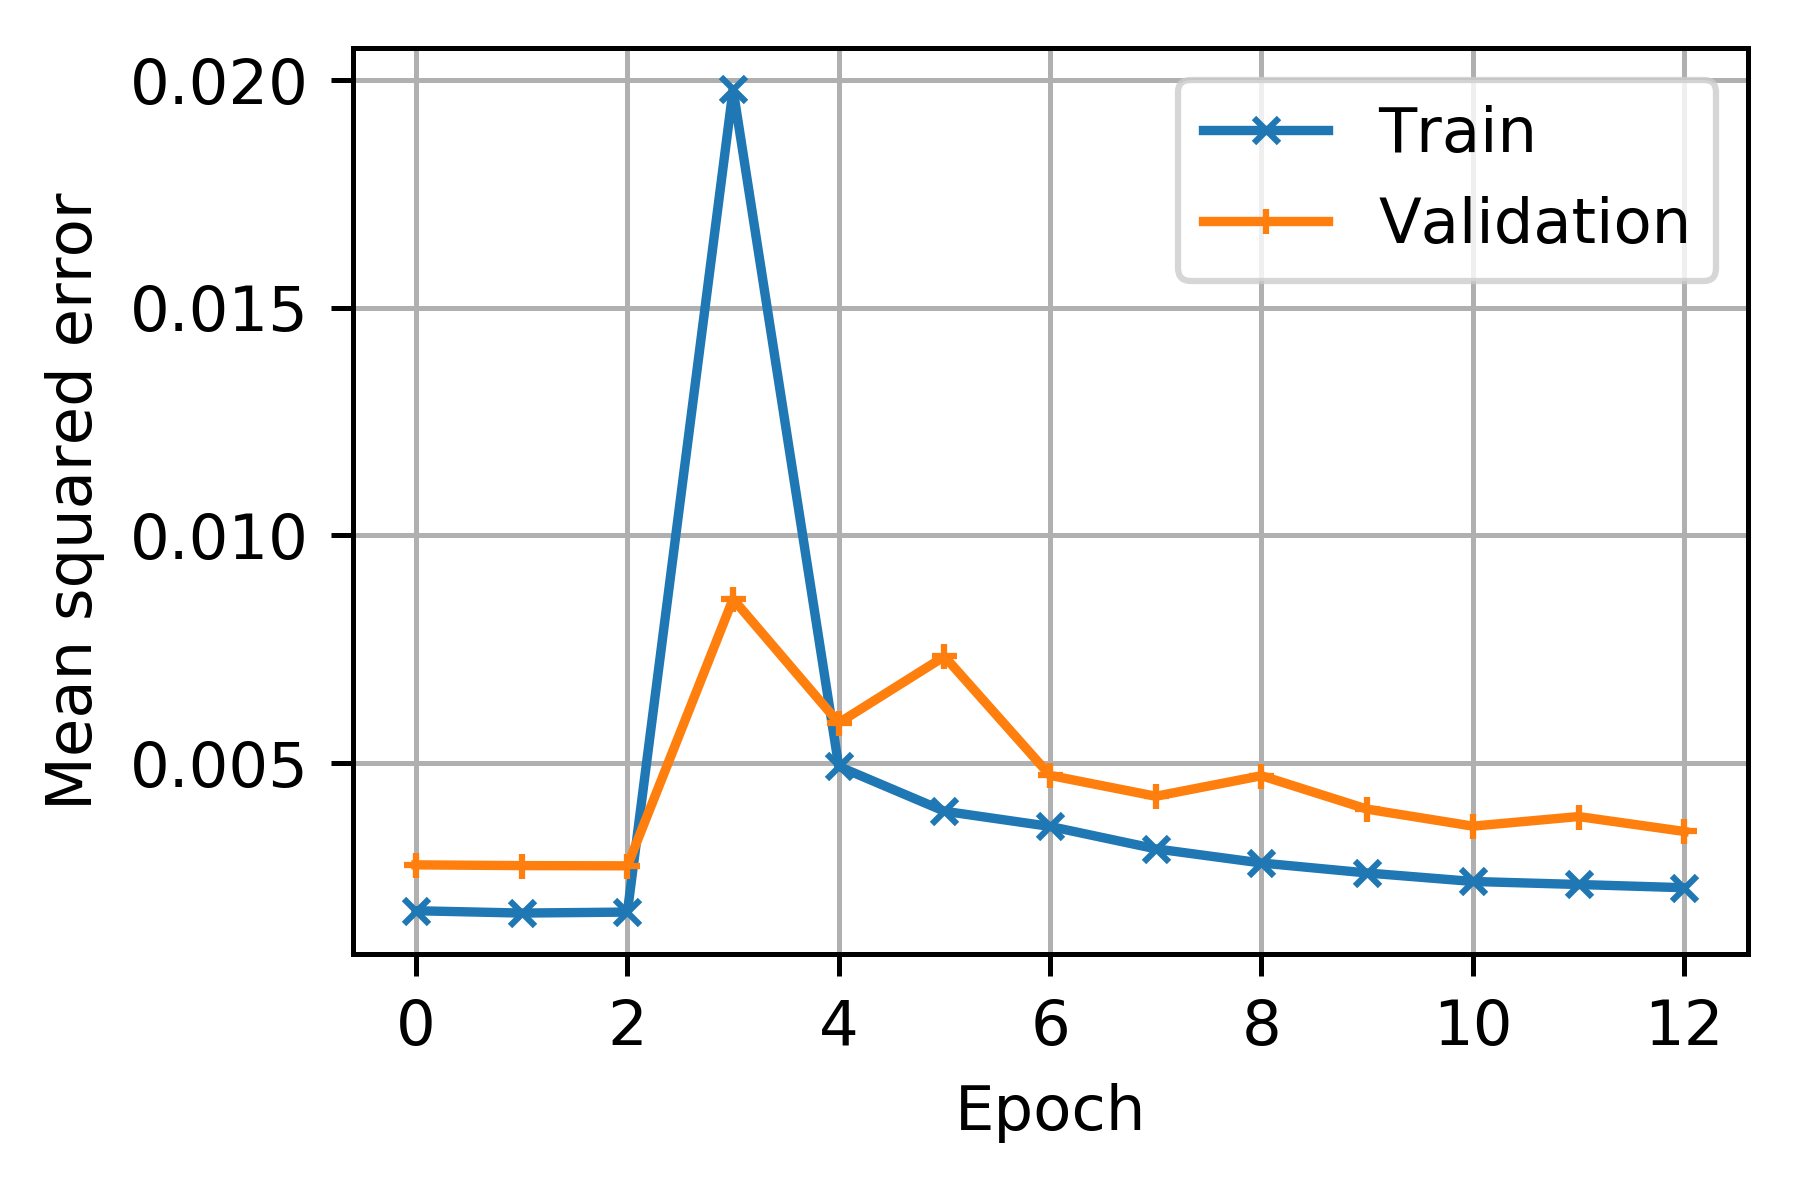

In [25]:
#Saving training history
np.save("../Data/loss_20190614-MRDataset-residual_fc_unet_fi_data_augmentation_compress_10_20.npy",np.array(hist.history['loss']))
np.save("../Data/val_loss_20190614-MRDataset-residual_fc_unet_fi_data_augmentation_compress_10_20.npy",np.array(hist.history['val_loss']))

loss = np.array(hist.history['loss'])
val_loss = np.array(hist.history['val_loss'])
plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()

# =============================================================
<a name='scratchpad'/>

# Scratchpad

In [113]:
from keras import backend as K, regularizers
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Conv2DTranspose, Lambda, Add, Subtract, LeakyReLU, \
                         MaxPooling2D, concatenate, UpSampling2D,\
                         Multiply, Dense, Flatten, Reshape


def tf_dct2d(im):
    return K.tf.transpose(K.tf.spectral.dct(K.tf.transpose(K.tf.spectral.dct(im,type=2,axis=-1,norm='ortho'),perm=[0,2,1,3]),type=2,axis=-1,norm='ortho'),perm=[0,2,1,3])
    
    
def tf_idct2d(mat): 
    return K.tf.transpose(K.tf.spectral.idct(K.tf.transpose(K.tf.spectral.idct(mat,type=2,axis=-1,norm='ortho'),perm=[0,2,1,3]),type=2,axis=-1,norm='ortho'),perm=[0,2,1,3])


# Modified from:
# https://www.programcreek.com/python/example/90422/tensorflow.extract_image_patches
def extract_patches(x, patsize=(1,8,8,1), strides=(1,8,8,1), rates=(1,1,1,1)):
    patches = K.tf.extract_image_patches(
        x,
        patsize,
        strides,
        rates,
        padding="SAME"
    )
    patches_shape = K.tf.shape(patches)
    return K.tf.reshape(patches, 
                      [K.tf.reduce_prod(patches_shape[0:3]), 
                       8, 8, 1])  # returns [batch_patches, h, w, c] 


# x = orig
# y = orig in patches
def extract_patches_inverse(x, y):
    _x = K.tf.zeros_like(x)
    _y = extract_patches(_x)
    grad = K.tf.gradients(_y, _x)[0]
    # Divide by grad, to "average" together the overlapping patches
    # otherwise they would simply sum up
    return K.tf.gradients(_y, _x, grad_ys=y)[0] / grad


def dct_layer(image):
    """
    Input: single channel array representing image domain data
    Output: single channel array representing dct coefficient data
    """
    
    patches = extract_patches(image)
    dct_patches = tf_dct2d(patches)
    dct_image = extract_patches_inverse(image, dct_patches)
    
    return dct_image


def idct_layer(dctdata):
    """
    Input: a list of input data. See below
    Output: single channel array representing image domain data
    
    data_list: data_list[0] = dct matrix (in patches) [total_num_patches, patch_size, patch_size, chnl]
               data_list[1] = single channel image in original dimensions [batch, H, W, chnl]
    """
    
    patches = extract_patches(dctdata)
    image_patches = tf_idct2d(patches)
    image = extract_patches_inverse(dctdata, image_patches)
    
    return image


def dct_dc_layer(data_list): #, dctmat, jpeg_dctmat, qmat):
    """
    param data_list: data_list[0] = dct matrix; 
                     data_list[1] = jpeg-compressed dct matrix; 
                     data_list[2] = quantization matrix
    
    
    param dctmat: quantization matrix for each image
    param jpeg_dctmat: single channel array representing dct coefficient data
    param qmat: quantization matrix
    Output: dct coefficients restricted to range
    """
    # Clip range: X_recon = [(X_jpeg*Q - Q/2), (X_jpeg*Q + Q/2)]

    clip_low = Subtract()([data_list[1], data_list[2] * 0.5])
    clip_high = Add()([data_list[1], data_list[2] * 0.5])
    return K.tf.clip_by_value(data_list[0], clip_low, clip_high)

    #return K.tf.clip_by_value(dctmat, clip_low, clip_high)
    

def fft_layer(image):
    """
    Input: 2-channel array representing image domain complex data
    Output: 2-channel array representing k-space complex data
    """

    # get real and imaginary portions
    real = Lambda(lambda image: image[:, :, :, 0])(image)
    imag = Lambda(lambda image: image[:, :, :, 1])(image)

    image_complex = K.tf.complex(real, imag)  # Make complex-valued tensor
    kspace_complex = K.tf.fft2d(image_complex)

    # expand channels to tensorflow/keras format
    real = K.tf.expand_dims(K.tf.real(kspace_complex), -1)
    imag = K.tf.expand_dims(K.tf.imag(kspace_complex), -1)

    # generate 2-channel representation of k-space
    kspace = K.tf.concat([real, imag], -1)
    
    return kspace


def ifft_layer(kspace_2channel):
    """
    Input: 2-channel array representing k-space
    Output: 2-channel array representing image domain
    """
    #get real and imaginary portions
    real = Lambda(lambda kspace_2channel : kspace_2channel[:,:,:,0])(kspace_2channel)
    imag = Lambda(lambda kspace_2channel : kspace_2channel[:,:,:,1])(kspace_2channel)
    
    kspace_complex = K.tf.complex(real,imag) # Make complex-valued tensor
    image_complex = K.tf.ifft2d(kspace_complex)
    
    # expand channels to tensorflow/keras format
    real = K.tf.expand_dims(K.tf.real(image_complex),-1)
    imag = K.tf.expand_dims(K.tf.imag(image_complex),-1)
    
    # generate 2-channel representation of image domain
    image_complex_2channel = K.tf.concat([real, imag], -1)
    return image_complex_2channel


def rfft_layer(image):
    """
    Input: single-channel array representing image domain real data
    Output: 2-channel array representing k-space complex data
    """
    print("image: ", image.shape)
    empty = K.tf.zeros_like(image)
    print("empty: ", empty.shape)
    image_complex = K.tf.complex(image,empty)
    print("image_complex: ", image_complex.shape)
    
    kspace_complex = K.tf.fft2d(image_complex)
    print("kspace_complex: ", kspace_complex.shape)
        
    real = K.tf.real(kspace_complex)
    imag = K.tf.imag(kspace_complex)

    # generate 2-channel representation of k-space
    kspace = K.tf.concat([real, imag], -1)
    print("kspace: ", kspace.shape)

    return kspace


def abs_layer(complex_data):
    """
    Input: 2-channel array representing complex data
    Output: 1-channel array representing magnitude of complex data
    """
    #get real and imaginary portions
    real = Lambda(lambda complex_data : complex_data[:,:,:,0])(complex_data)
    imag = Lambda(lambda complex_data : complex_data[:,:,:,1])(complex_data)
    
    mag = K.tf.abs(K.tf.complex(real,imag))
    mag = K.tf.expand_dims(mag, -1)
    return mag


def fc_dct_layer(image):
    """
    Input: single channel array representing image domain data
    Output: single channel array representing dct coefficient data (in patches)
    """
    
    patches = extract_patches(image)
    dct_patches = tf_dct2d(patches)
    
    return dct_patches


def fc_idct_layer(data_list):
    """
    Input: single channel array representing dct coefficient data (in patches)
    Output: single channel array representing image domain data
    
    data_list: data_list[0] = dct matrix (in patches) [total_num_patches, patch_size, patch_size, chnl]
               data_list[1] = single channel image in original dimensions [batch, H, W, chnl]
    """
    
    image_patches = tf_idct2d(data_list[0])
    image = extract_patches_inverse(data_list[1], image_patches)
    
    return image


def fc_fft_layer(image):
    """
    Input: single-channel array representing image domain real data
    Output: 2-channel array representing k-space complex data
    """
    
    #real = Lambda(lambda image: image[:, :, :, 0])(image)
    #imag = Lambda(lambda image: image[:, :, :, 1])(image)
    
    image_pat = Lambda(extract_patches)(image)
    empty = K.tf.zeros_like(image_pat)
    
    image_complex_pat = K.tf.complex(image_pat,empty)
    kspace_complex = K.tf.fft2d(image_complex_pat)
    kspace_complex = K.tf.fft2d(kspace_complex)
    
    real = K.tf.real(kspace_complex)
    imag = K.tf.imag(kspace_complex)

    # generate 2-channel representation of k-space
    kspace = K.tf.concat([real, imag], -1)
    
    print("image_pat: ", image_pat.shape)
    print("empty: ", empty.shape)
    print("image_complex_pat: ", image_complex_pat.shape)
    print("kspace_complex: ", kspace_complex.shape)
    print("real: ", real.shape)
    print("imag: ", imag.shape)
    print("kspace: ", kspace.shape)

    return kspace


def fc_ifft_layer(data_list):
    """
    Input: 2-channel array representing k-space
    Output: 2-channel array representing image domain
    
    data_list: data_list[0] = k-space (in patches) [total_num_patches, patch_size, patch_size, chnl]
               data_list[1] = single channel image in original dimensions [batch, H, W, chnl]
    """
    
    print("data_list[0] (k-space patches): ", data_list[0].shape)
    
    #get real and imaginary portions
    kspace_2channel = K.tf.identity(data_list[0])
    
    real = Lambda(lambda kspace_2channel : kspace_2channel[:,:,:,0])(kspace_2channel)
    imag = Lambda(lambda kspace_2channel : kspace_2channel[:,:,:,1])(kspace_2channel)
    
    kspace_complex = K.tf.complex(real,imag) # Make complex-valued tensor
    image_complex = K.tf.ifft2d(kspace_complex)
    image_complex = K.tf.ifft2d(image_complex)
    
    mag_patches = K.tf.abs(image_complex)
    image = extract_patches_inverse(data_list[1], mag_patches)
    
    
    print("data_list[0] (k-space patches): ", data_list[0].shape)
    print("kspace_2channel (k-space patches (copy)): ", kspace_2channel.shape)
    print("real: ", real.shape)
    print("imag: ", imag.shape)
    print("kspace_complex: ", kspace_complex.shape)
    print("image_complex: ", image_complex.shape)
    print("mag_patches: ", mag_patches.shape)
    print("data_list[1]: ", data_list[1].shape)
    print("image: ", image.shape)
    
    
    return image


def dense_block(dense_input, chnl=1):
    
    print("dense_input", dense_input.shape)
    
    inputs_flat = Flatten(input_shape=dense_input.shape)(dense_input)
    print("inputs_flat", inputs_flat.shape)
    
    dense1 = Dense(64*chnl, input_shape=inputs_flat.shape, activation='tanh')(inputs_flat)
    dense2 = Dense(64*chnl, activation='tanh')(dense1)
    dense3 = Dense(128*chnl, activation='tanh')(dense2)
    dense4 = Dense(128*chnl, activation='tanh')(dense3)
    dense5 = Dense(256*chnl, activation='tanh')(dense4)
    dense6 = Dense(256*chnl, activation='tanh')(dense5)
    dense7 = Dense(128*chnl, activation='tanh')(dense6)
    dense8 = Dense(128*chnl, activation='tanh')(dense7)
    dense9 = Dense(64*chnl, activation='tanh')(dense8)
    last_dense = Dense(64*chnl, activation='tanh')(dense9)
    print("last_dense", last_dense.shape)

    #output_layer = Reshape(8,8)(dense4)
    output_layer = Reshape((8,8,chnl), input_shape=inputs_flat.shape)(last_dense)
    print("output_layer", output_layer.shape)

    return output_layer


def automap_block(inputs, patsize = 8, chnl=1):
    
    flat = Flatten(input_shape=(patsize,patsize,chnl))(inputs)
    
    dense1 = Dense(patsize*patsize*chnl, activation='tanh')(flat)
    dense2 = Dense(patsize*patsize, activation='tanh')(dense1)
    dense3 = Dense(patsize*patsize, activation='tanh')(dense2)
    dense4 = Reshape((patsize, patsize,1), input_shape=dense3.shape)(dense3)
    
    conv1 = Conv2D(int(patsize*patsize/2), kernel_size=(5,5), strides=(1,1), activation='relu',kernel_regularizer=regularizers.l1(0.01))(dense4)
    conv2 = Conv2D(int(patsize*patsize/2), kernel_size=(5,5), strides=(1,1), activation='relu',kernel_regularizer=regularizers.l1(0.01))(conv1)
    conv3 = Conv2DTranspose(1, kernel_size=(9,9), strides=(1,1), activation='relu')(conv2)
    
    return conv3 

    model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation = 'relu', data_format="channels_first", kernel_regularizer=regularizers.l1(0.01)) )
    model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), activation = 'relu', data_format="channels_first", kernel_regularizer=regularizers.l1(0.01)) )    
    model.add(Conv2DTranspose(filters=1, kernel_size=(9,9), strides=(1,1), activation='relu', data_format="channels_first" ) )


def unet_block(unet_input, kshape=(3, 3), chnl=1):
    """
    :param unet_input: Input layer
    :param kshape: Kernel size
    :return: single channel
    """

    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(unet_input)
    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(conv1)
    conv1 = Conv2D(48, kshape, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(conv2)
    conv2 = Conv2D(64, kshape, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(conv3)
    conv3 = Conv2D(128, kshape, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(conv4)
    conv4 = Conv2D(256, kshape, activation='relu', padding='same')(conv4)

    up1 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(up1)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(conv5)
    conv5 = Conv2D(128, kshape, activation='relu', padding='same')(conv5)

    up2 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(up2)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(conv6)
    conv6 = Conv2D(64, kshape, activation='relu', padding='same')(conv6)

    up3 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(up3)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(conv7)
    conv7 = Conv2D(48, kshape, activation='relu', padding='same')(conv7)

    conv8 = Conv2D(chnl, (1, 1), activation='linear')(conv7)
    out = Add()([conv8, unet_input])
    return out


def deep_cascade_unet(depth_str='di', H=256, W=256, kshape=(3, 3), useDC = True):
    """
    :param depth_str: string that determines the depth of the cascade and the domain of each
    subnetwork
    :param H: Image height
    :param W: Image width
    :param kshape: Kernel size
    :param nf: number of filters in each convolutional layer
    :return: Deep Cascade Flat Unrolled model
    """

    channels = 1  # inputs are represented as single channel images (grayscale)
    inputs = Input(shape=(H, W, channels))
    qmat = Input(shape=(H, W, channels))
    layers = [inputs]
    dct_flag = False # flag whether input is in the image domain (false) or dct domain (true)
    kspace_flag = False
    
    # intermed_list = []

    for (jj,ii) in enumerate(depth_str):
        print(jj, ii)
        if ii == 'd':
            if not dct_flag: # if in image domain
                # Apply DCT 
                layers.append(Lambda(dct_layer)(layers[-1])) 
                print("Append DCT layer")
                dct_flag = True
        elif ii == 'k':
            if not kspace_flag: # if in image domain
                # Apply FFT 
                print("Append rFFT layer")
                layers.append(Lambda(rfft_layer)(layers[-1])) 
                kspace_flag = True
        elif ii == 'i':
            if dct_flag: # if in dct domain
                layers.append(Lambda(idct_layer)(layers[-1])) 
                print("Append iDCT layer")
                dct_flag = False
            if kspace_flag: # if in k-space
                print("Append iFFT layer")
                layers.append(Lambda(ifft_layer)(layers[-1]))
                print("Append magnitude layer")
                layers.append(Lambda(abs_layer)(layers[-1]))
                kspace_flag = False
        else:
            print("Layer not recognized. Only 'd', 'k', and 'i' layers are currently supported.")
            break;

        if kspace_flag:
            # Append 2-channel U-net block
            layers.append(unet_block(layers[-1], kshape, chnl=2))
            print("Append U-net (2-channel) block")
        else:
            # Append 1-channel U-net block
            layers.append(unet_block(layers[-1], kshape))
            print("Append U-net block")
        
        if useDC:
            # Append a data consistency layer
            print("Data consistency layer")
            if dct_flag: # if in the DCT domain
                print("Currently in the DCT domain")
                print("Append DC layer")
                print("Append iDCT layer")
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs, qmat]))
                intermed = Lambda(idct_layer)(layers[-1])
                layers.append(intermed)
                dct_flag = False
            elif kspace_flag: # if in k-space
                print("Currently in the FFT domain")
                print("Append iFFT-abs layers")
                print("Append DCT-DC-iDCT layers")
                layers.append(Lambda(ifft_layer)(layers[-1]))
                layers.append(Lambda(abs_layer)(layers[-1]))
                layers.append(Lambda(dct_layer)(layers[-1])) 
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs, qmat]))
                intermed = Lambda(idct_layer)(layers[-1])
                layers.append(intermed)
                kspace_flag = False
            else: # if in the image domain
                print("Currently in the image domain")
                print("Append DCT-DC-iDCT layers")
                layers.append(Lambda(dct_layer)(layers[-1])) 
                layers.append(Lambda(dct_dc_layer)([layers[-1], inputs, qmat]))
                layers.append(Lambda(idct_layer)(layers[-1])) 
        else:
            intermed = layers[-1] 
            
        if not (jj + 1) % len(depth_str) > 0: # check if there is a next element
            if dct_flag: # if in DCT domain
                layers.append(Lambda(idct_layer)(layers[-1])) 
                print("Append iDCT layer")
                dct_flag = False
            elif kspace_flag: # if in k-space
                print("Append iFFT layer")
                layers.append(Lambda(ifft_layer)(layers[-1]))
                print("Append magnitude layer")
                layers.append(Lambda(abs_layer)(layers[-1]))
                kspace_flag = False
            
        #intermed_list = [intermed_list, intermed]
        
    if useDC:
        outputs = [layers[-1], intermed]
    else:
        outputs = [layers[-1], layers[1]]
    
    model = Model(inputs=[inputs,qmat], outputs=outputs)
    return model


def deep_cascade_fc_unet(depth_str='fi', H=256, W=256, kshape=(3, 3), useDC = True):
    """
    :param depth_str: string that determines the depth of the cascade and the domain of each
    subnetwork
    :param H: Image height
    :param W: Image width
    :param kshape: Kernel size
    :param nf: number of filters in each convolutional layer
    :return: Deep Cascade Flat Unrolled model
    """

    channels = 1  # inputs are represented as single channel images (grayscale)
    inputs = Input(shape=(H, W, channels))
    qmat = Input(shape=(H, W, channels))
    
    if useDC:
        qmat_pat = Lambda(extract_patches)(qmat)
        inputs_pat = Lambda(extract_patches)(inputs)
    
    layers = [inputs]
    fc_flag = False # flag whether input is in the image domain (false) or dct domain (true)
                    # i.e. input is in image domain
    
    for (jj,ii) in enumerate(depth_str):
        print(jj,ii)
        if ii == 'f':
            if not fc_flag: # image domain
                print("Append DCT layer (patches)")
                layers.append(Lambda(fc_dct_layer)(layers[-1]))
                print("Append FC/dense block")
                layers.append(dense_block(layers[-1]))
                
                if useDC:
                    print("Append data consistency block")
                    layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_pat, qmat_pat]))
                
                print("Append iDCT layer (patches)")
                intermed = Lambda(fc_idct_layer)([layers[-1], inputs])
                layers.append(intermed)                
                fc_flag = True
            else: # DCT domain
                print("Append FC/dense block")
                layers.append(dense_block(layers[-1]))                
        elif ii == 'i':
            if not fc_flag: # image domain
                print("Append U-net block")
                layers.append(unet_block(layers[-1], kshape))
                
                if useDC:
                    print("Append DCT layer (patches)")
                    layers.append(Lambda(fc_dct_layer)(layers[-1]))
                    print("Append data consistency block")
                    layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_pat, qmat_pat]))
                    print("Append iDCT layer (patches)")
                    layers.append(Lambda(fc_idct_layer)([layers[-1], inputs]))             
                    
                fc_flag = False
            else: # DCT domain
                #layers.append(Lambda(fc_idct_layer)([layers[-1], inputs])) 
                #print("Append iDCT layer (patches)")
                print("Append U-net block")
                layers.append(unet_block(layers[-1], kshape))
                
                if useDC:
                    print("Append DCT layer (patches)")
                    layers.append(Lambda(fc_dct_layer)(layers[-1]))
                    print("Append data consistency block")
                    layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_pat, qmat_pat]))
                    print("Append iDCT layer (patches)")
                    layers.append(Lambda(fc_idct_layer)([layers[-1], inputs]))     
                    
                fc_flag = False
        else:
            print("Layer not recognized. Only 'f' and 'i' layers are currently supported.")
            break;
            
        # If in DCT domain and it is last cascade, bring back to image domain
        if not ((jj + 1) % len(depth_str) > 0) and ii == 'f' and fc_flag:
            print("Append iDCT layer (patches)")
            layers.append(Lambda(fc_idct_layer)([layers[-1], inputs])) 
                        
    model = Model(inputs=[inputs,qmat], outputs=[layers[-1],intermed])
    return model


def deep_cascade_fc_ksp_unet(depth_str='fi', H=256, W=256, kshape=(3, 3), useDC = True):
    """
    :param depth_str: string that determines the depth of the cascade and the domain of each
    subnetwork
    :param H: Image height
    :param W: Image width
    :param kshape: Kernel size
    :param nf: number of filters in each convolutional layer
    :return: Deep Cascade Flat Unrolled model
    """

    channels = 1  # inputs are represented as single channel images (grayscale)
    inputs = Input(shape=(H, W, channels))
    qmat = Input(shape=(H, W, channels))
    
    if useDC:
        qmat_pat = Lambda(extract_patches)(qmat)
        inputs_pat = Lambda(extract_patches)(inputs)
    
    layers = [inputs]
    fc_flag = False # flag whether input is in the image domain (false) or dct domain (true)
                    # i.e. input is in image domain
           
    for (jj,ii) in enumerate(depth_str):
        print(jj,ii)
        if ii == 'f':
            if not fc_flag: # image domain
                print("Append FFT layer (patches)")
                layers.append(Lambda(fc_fft_layer)(layers[-1]))
                print("Append FC/dense block")
                layers.append(dense_block(layers[-1],chnl=2))
                print("Append iFFT layer (patches)")
                layers.append(Lambda(fc_ifft_layer)([layers[-1], inputs])) 
                fc_flag = False
            else: # k-space domain
                print("Append FC/dense block")
                layers.append(dense_block(layers[-1],chnl=2))
        elif ii == 'i':
            if not fc_flag: # image domain
                print("Append U-net block")
                layers.append(unet_block(layers[-1], kshape))
                fc_flag = False
            else: # k-space domain
                print("Append U-net block")
                layers.append(unet_block(layers[-1], kshape))                
                fc_flag = False
        else:
            print("Layer not recognized. Only 'f' and 'i' layers are currently supported.")
            break;
            
        if useDC:
            if fc_flag:
                print("Append iFFT layer (patches)")
                layers.append(Lambda(fc_ifft_layer)([layers[-1], inputs]))
                fc_flag = False
                
            print("Append DCT layer (patches)")
            layers.append(Lambda(fc_dct_layer)(layers[-1]))
            print("Append data consistency block")
            layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_pat, qmat_pat]))
            print("Append iDCT layer (patches)")
            if jj == 0:
                intermed = Lambda(fc_idct_layer)([layers[-1], inputs])
                layers.append(intermed)
            else:
                layers.append(Lambda(fc_idct_layer)([layers[-1], inputs]))
        else:
            if jj == 0:
                intermed = layers[-1]
            
        if not ((jj + 1) % len(depth_str) > 0) and ii == 'f' and fc_flag:
            print("Append iFFT layer (patches)")
            layers.append(Lambda(fc_ifft_layer)([layers[-1], inputs]))      
        
    model = Model(inputs=[inputs,qmat], outputs=[layers[-1],intermed])
    return model


def automap(depth_str='fi', H=256, W=256, kshape=(3, 3), useDC = True):
    """
    :param depth_str: string that determines the depth of the cascade and the domain of each
    subnetwork
    :param H: Image height
    :param W: Image width
    :param kshape: Kernel size
    :param nf: number of filters in each convolutional layer
    :return: Deep Cascade Flat Unrolled model
    """

    channels = 1  # inputs are represented as single channel images (grayscale)
    inputs = Input(shape=(H, W, channels))
    qmat = Input(shape=(H, W, channels))

    if useDC:
        qmat_pat = Lambda(extract_patches)(qmat)
        inputs_pat = Lambda(extract_patches)(inputs)

    layers = [inputs]
    fc_flag = False # flag whether input is in the image domain (false) or dct domain (true)
                    # i.e. input is in image domain

    layers.append(Lambda(fc_fft_layer)(inputs))
    layers.append(automap_block(layers[-1], chnl=2))

    model = Model(inputs=[inputs,qmat], outputs=[layers[-1],layers[-1]])
    return model
                  
                  
#     for (jj,ii) in enumerate(depth_str):
#         print(jj,ii)
#         if ii == 'f':
#             if not fc_flag: # image domain
#                 print("Append FFT layer (patches)")
#                 layers.append(Lambda(fc_fft_layer)(layers[-1]))
#                 print("Append FC/dense block")
#                 layers.append(dense_block(layers[-1],chnl=2))
#                 print("Append iFFT layer (patches)")
#                 layers.append(Lambda(fc_ifft_layer)([layers[-1], inputs])) 
#                 fc_flag = False
#             else: # k-space domain
#                 print("Append FC/dense block")
#                 layers.append(dense_block(layers[-1],chnl=2))
#         elif ii == 'i':
#             if not fc_flag: # image domain
#                 print("Append U-net block")
#                 layers.append(unet_block(layers[-1], kshape))
#                 fc_flag = False
#             else: # k-space domain
#                 print("Append U-net block")
#                 layers.append(unet_block(layers[-1], kshape))                
#                 fc_flag = False
#         else:
#             print("Layer not recognized. Only 'f' and 'i' layers are currently supported.")
#             break;
            
#         if useDC:
#             if fc_flag:
#                 print("Append iFFT layer (patches)")
#                 layers.append(Lambda(fc_ifft_layer)([layers[-1], inputs]))
#                 fc_flag = False
                
#             print("Append DCT layer (patches)")
#             layers.append(Lambda(fc_dct_layer)(layers[-1]))
#             print("Append data consistency block")
#             layers.append(Lambda(dct_dc_layer)([layers[-1], inputs_pat, qmat_pat]))
#             print("Append iDCT layer (patches)")
#             if jj == 0:
#                 intermed = Lambda(fc_idct_layer)([layers[-1], inputs])
#                 layers.append(intermed)
#             else:
#                 layers.append(Lambda(fc_idct_layer)([layers[-1], inputs]))
#         else:
#             if jj == 0:
#                 intermed = layers[-1]
            
#         if not ((jj + 1) % len(depth_str) > 0) and ii == 'f' and fc_flag:
#             print("Append iFFT layer (patches)")
#             layers.append(Lambda(fc_ifft_layer)([layers[-1], inputs]))      


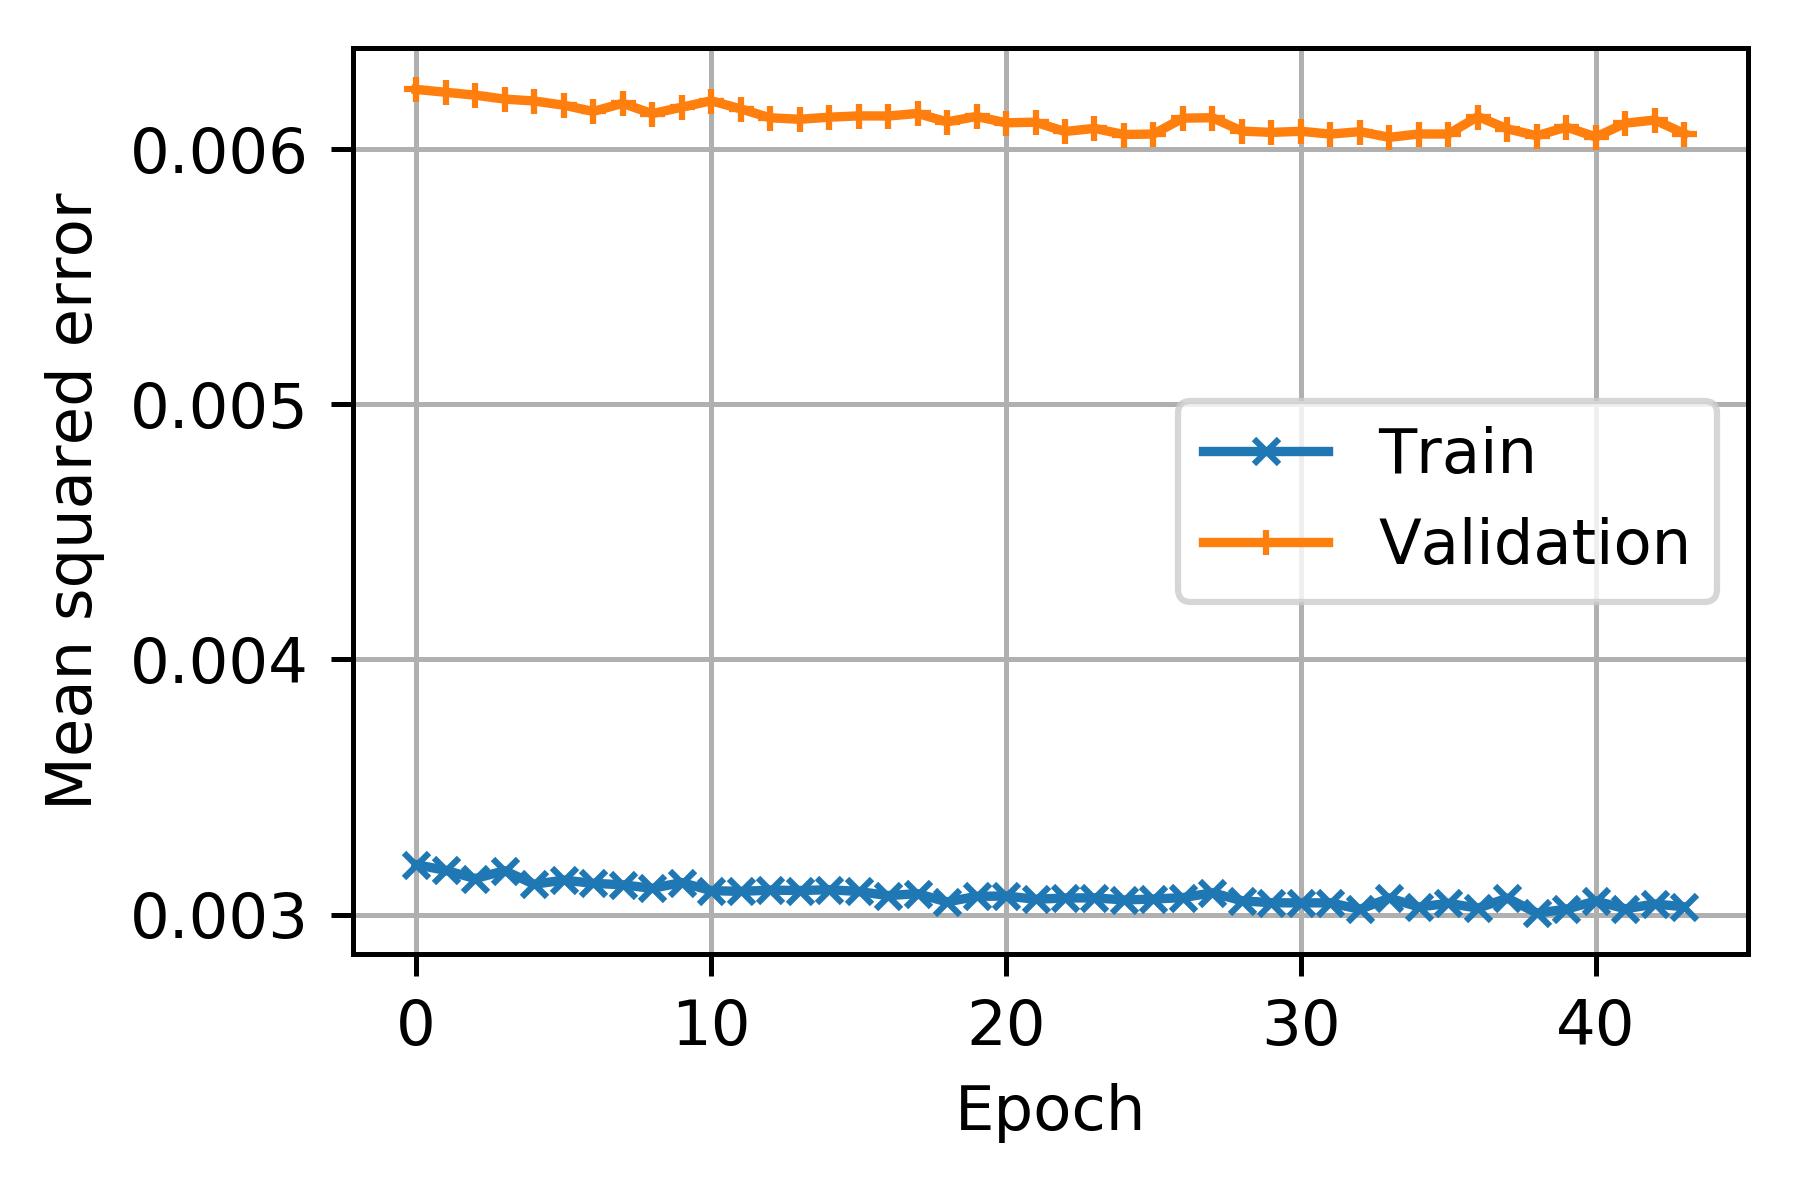

In [30]:
import numpy as np
import matplotlib.pylab as plt

# View saved training history
loss = np.load("../Data/loss_20190612-imagenet-residual_wnet_ki_data_augmentation_compress_10_20.npy")
val_loss = np.load("../Data/val_loss_20190612-imagenet-residual_wnet_ki_data_augmentation_compress_10_20.npy")

plt.figure(figsize = (4,4/1.5),facecolor = "w",dpi = 450)
plt.plot(loss,'x-', markersize = 4,label = "Train")
plt.plot(val_loss,'+-',markersize = 4,label = "Validation")
plt.legend()
plt.grid()
plt.xlabel("Epoch")
plt.ylabel("Mean squared error")
plt.show()